In [1]:
!git clone https://github.com/ksideks/UCSD.git

fatal: docelowa ścieżka „UCSD” już istnieje i nie jest pustym katalogiem.


In [2]:
!pip install keras-layer-normalization

In [3]:
TestVideoFile = {}
TestVideoFile[1] = range(59,152)
TestVideoFile[2] = range(49,175)
TestVideoFile[3] = range(90,200)
TestVideoFile[4] = range(30,168)
TestVideoFile[5] = list(range(4,90)) + list(range(139,200))
TestVideoFile[6] = list(range(0,100)) + list(range(109,200))
TestVideoFile[7] = range(0,175)
TestVideoFile[8] = range(0,94)
TestVideoFile[9] = range(0,48)
TestVideoFile[10] = range(0,140)
TestVideoFile[11] = range(69,165)
TestVideoFile[12] = range(130,200)
TestVideoFile[13] = range(0,156)
TestVideoFile[14] = range(6,200)
TestVideoFile[15] = range(137,200)
TestVideoFile[16] = range(122,200)
TestVideoFile[17] = range(0,47)
TestVideoFile[18] = range(53,120)
TestVideoFile[19] = range(63,138)
TestVideoFile[20] = range(44,175)
TestVideoFile[21] = range(30,200)
TestVideoFile[22] = range(16,107)
TestVideoFile[23] = range(8,165)
TestVideoFile[24] = range(49,171)
TestVideoFile[25] = range(39,135)
TestVideoFile[26] = range(77,144)
TestVideoFile[27] = range(9,122)
TestVideoFile[28] = range(104,200)
TestVideoFile[29] = list(range(0,15)) + list(range(44,113))
TestVideoFile[30] = range(174,200)
TestVideoFile[31] = range(0,180)
TestVideoFile[32] = list(range(0,52)) + list(range(64,115))
TestVideoFile[33] = range(4,165)
TestVideoFile[34] = range(0,121)
TestVideoFile[35] = range(85,200)
TestVideoFile[36] = range(14,108)

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [5]:
class Config:
  DATASET_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  TEST_PATH ="UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
  SINGLE_TEST_VIDEO_FILE = 1
  SINGLE_TEST_PATH = "UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
  BATCH_SIZE = 64
  EPOCHS = 50
  MODEL_PATH = "UCSD_v5/model_v11.hdf5"
  THRESHOLD = 0.95

In [6]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
def get_clips_by_stride(stride, frames_list, sequence_size):
    """ For data augmenting purposes.
    Parameters
    ----------
    stride : int
        The desired distance between two consecutive frames
    frames_list : list
        A list of sorted frames of shape 227 X 227
    sequence_size: int
        The size of the desired LSTM sequence
    Returns
    -------
    list
        A list of clips , 10 frames each
    """
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 227, 227, 1))
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    """
    Returns
    -------
    list
        A list of training sequences of shape (NUMBER_OF_SEQUENCES,SINGLE_SEQUENCE_SIZE,FRAME_WIDTH,FRAME_HEIGHT,1)
    """
    #####################################
    # cache = shelve.open(Config.CACHE_PATH)
    # return cache["datasetLSTM"]
    #####################################
    clips = []
    # loop over the training folders (Train000,Train001,..)
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            # loop over all the images in the folder (0.tif,1.tif,..,199.tif)
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((227, 227))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frames sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [7]:
import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model
def get_model(reload_model=True):
    """
    Parameters
    ----------
    reload_model : bool
        Load saved model or retrain it
    """
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})
    training_set = get_training_set()
    training_set = np.array(training_set)
    training_set = training_set.reshape(-1,10,227,227,1)
    
    seq = Sequential()
    
    #na podstawie oryginalu
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid", activation=None), batch_input_shape=(None, 10, 227, 227, 1)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid", activation=None)))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), strides=1, padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(128, (5, 5), strides=2, padding="valid", activation=None)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(1, (11, 11), strides=4, padding="valid", activation=None)))
    seq.add(LayerNormalization())
    
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    
    print(seq.summary())
    
    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-4)) #, decay=1e-5, epsilon=1e-6))
    
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS) #, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

2021-11-14 14:40:01.897135: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-14 14:40:01.897198: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
def get_single_test():
    sz = 200
    test = np.zeros(shape=(sz, 227, 227, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((227, 227))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

def evaluate(reload_model=False):
    model = get_model(reload_model)
    print("got model")
    test = get_single_test()
    print(test.shape)
    sz = test.shape[0] - 10 + 1
    sequences = np.zeros((sz, 10, 227, 227, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, sz):
        clip = np.zeros((10, 227, 227, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")
    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=Config.BATCH_SIZE)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,sz)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return sr, sequences

2021-11-14 14:40:37.058853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-14 14:40:37.058924: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-14 14:40:37.058956: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-14 14:40:37.059289: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 55, 55, 128)  15616     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 55, 55, 128)  256       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 26, 26, 64)   204864    
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 26, 26, 64)   128       
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 26, 26, 64)    2

/home/user/notebook/jupyterenv/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
22/22 [==============================] - 735s 32s/step - loss: 0.0568
Epoch 2/50
22/22 [==============================] - 706s 32s/step - loss: 0.0565
Epoch 3/50
22/22 [==============================] - 698s 32s/step - loss: 0.0560
Epoch 4/50
22/22 [==============================] - 685s 31s/step - loss: 0.0555
Epoch 5/50
22/22 [==============================] - 693s 31s/step - loss: 0.0547
Epoch 6/50
22/22 [==============================] - 686s 31s/step - loss: 0.0539
Epoch 7/50
22/22 [==============================] - 674s 31s/step - loss: 0.0529
Epoch 8/50
22/22 [==============================] - 694s 32s/step - loss: 0.0518
Epoch 9/50
22/22 [==============================] - 688s 31s/step - loss: 0.0507
Epoch 10/50
22/22 [==============================] - 684s 31s/step - loss: 0.0495
Epoch 11/50
22/22 [==============================] - 703s 32s/step - loss: 0.0483
Epoch 12/50
22/22 [==============================] - 680s 31s/step - loss: 0.0472
Epoch 13/50
22/22 [======

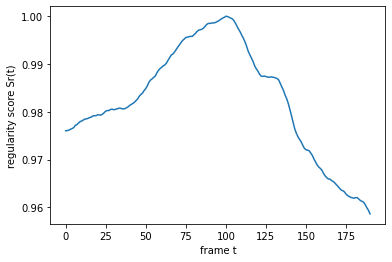

In [10]:
pr, before_reconstuction = evaluate(reload_model=True) #wygeneruj model

AUC:  0.0391705069124424
EER:  0.9139784946236559
EER THRESHOLD:  0.9827328416023147
Optimal threshold value is: 2.0


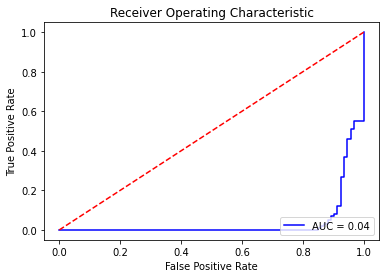

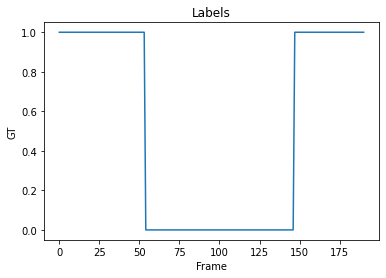

(0.0391705069124424, 0.9139784946236559)

In [11]:
from sklearn import metrics

def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  #wariant 1 
  # y_test = y_test[9:]
  #wariant 2
  #y_test = y_test[:191]
  #wariant 3
  y_test = y_test[5:196]

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001
GT:  1
got model
(200, 227, 227, 1)
got data


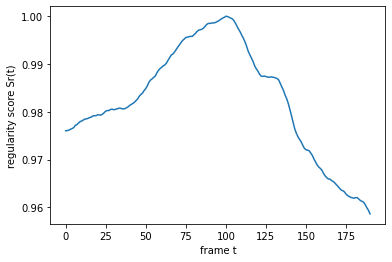

AUC:  0.0391705069124424
EER:  0.9139784946236559
EER THRESHOLD:  0.9827328416023147
Optimal threshold value is: 2.0


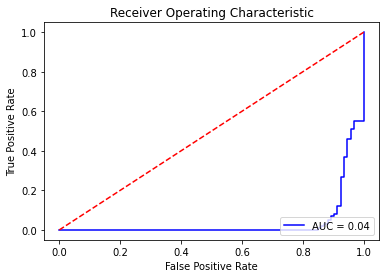

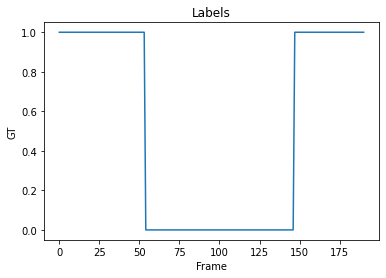

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002
GT:  2
got model
(200, 227, 227, 1)
got data


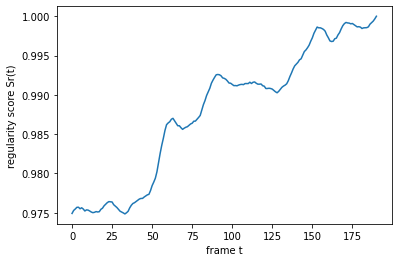

AUC:  0.321001221001221
EER:  1.0
EER THRESHOLD:  0.9768137883809855
Optimal threshold value is: 0.9984399682892908


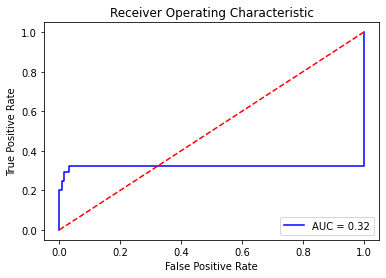

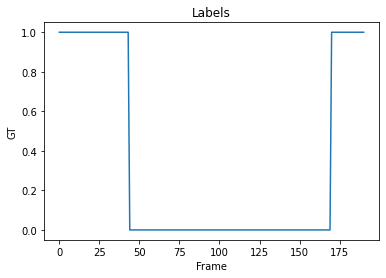

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003
GT:  3
got model
(200, 227, 227, 1)
got data


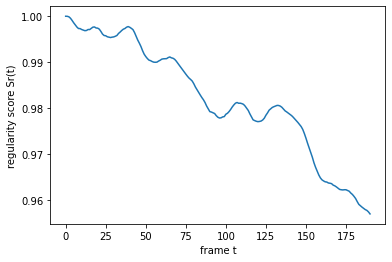

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.9828438735273334
Optimal threshold value is: 0.9828438735273334


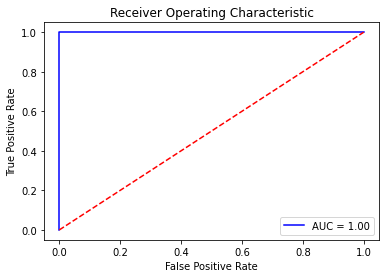

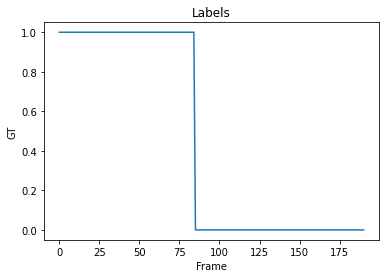

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004
GT:  4
got model
(200, 227, 227, 1)
got data


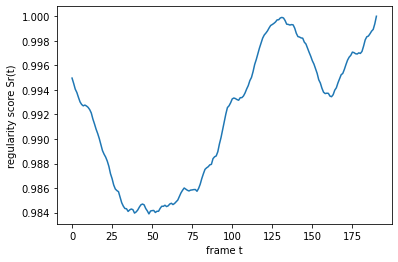

AUC:  0.6584632212195789
EER:  0.4057971014492754
EER THRESHOLD:  0.9934461995309479
Optimal threshold value is: 0.987767331601003


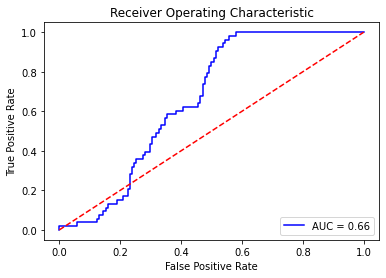

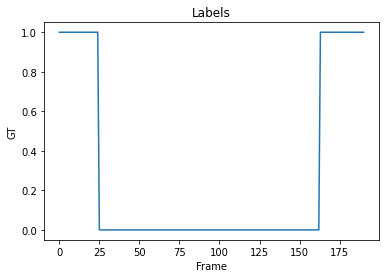

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005
GT:  5
got model
(200, 227, 227, 1)
got data


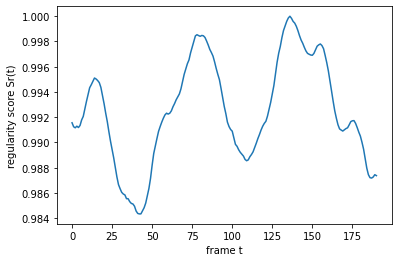

AUC:  0.49583213567116985
EER:  0.5070422535211268
EER THRESHOLD:  0.9920894366581605
Optimal threshold value is: 0.9885547109344427


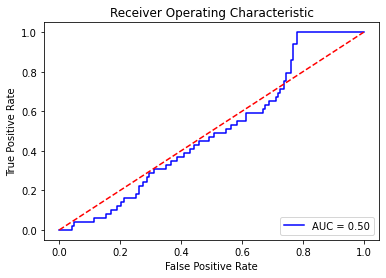

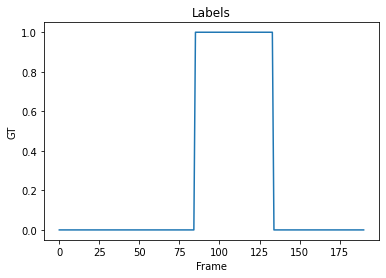

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test006
GT:  6
got model
(200, 227, 227, 1)
got data


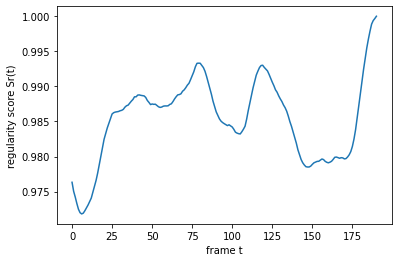

AUC:  0.3669108669108669
EER:  0.6208791208791209
EER THRESHOLD:  0.9843754205857367
Optimal threshold value is: 0.9833401547779196


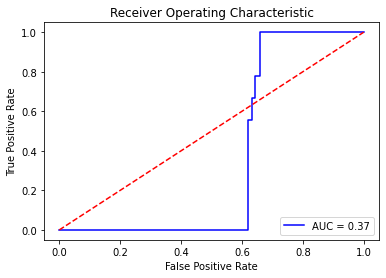

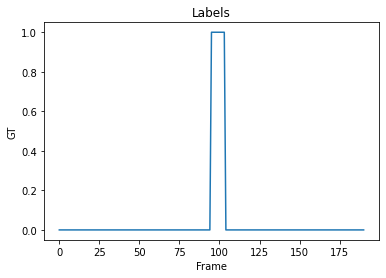

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test007
GT:  7
got model
(200, 227, 227, 1)
got data


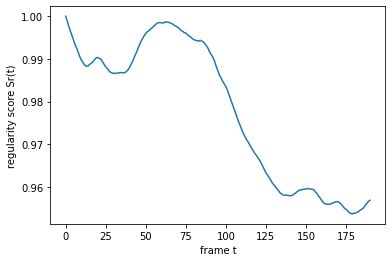

AUC:  0.010924369747899162
EER:  0.9470588235294117
EER THRESHOLD:  0.956688661949676
Optimal threshold value is: 2.0


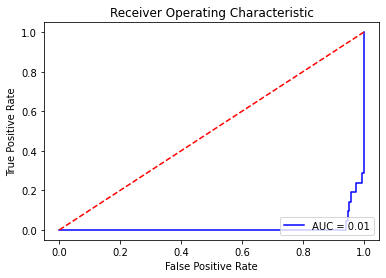

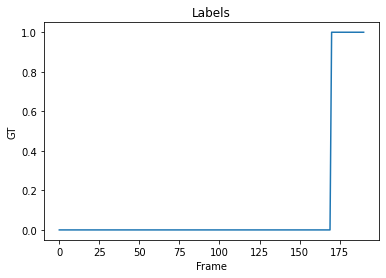

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test008
GT:  8
got model
(200, 227, 227, 1)
got data


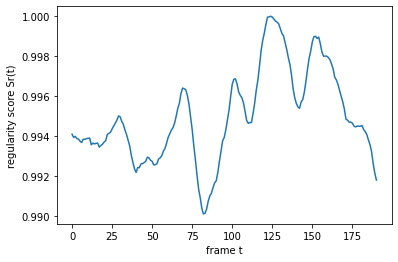

AUC:  0.8619740030843798
EER:  0.20224719101123595
EER THRESHOLD:  0.9944966282132948
Optimal threshold value is: 0.994448826529205


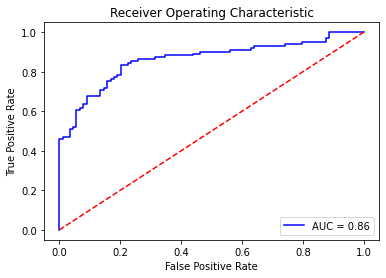

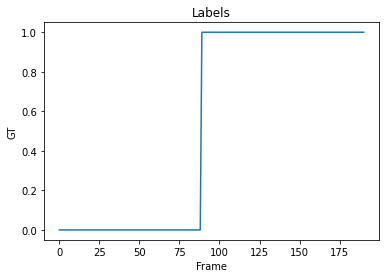

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test009
GT:  9
got model
(200, 227, 227, 1)
got data


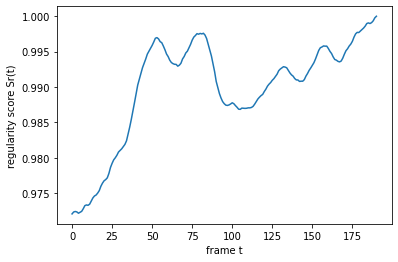

AUC:  0.9808296668761786
EER:  0.09302325581395349
EER THRESHOLD:  0.9878225326028104
Optimal threshold value is: 0.9868539846303854


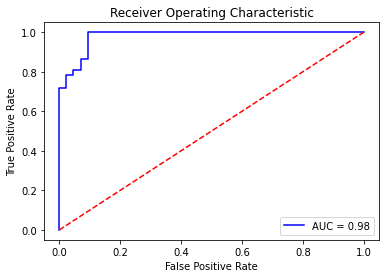

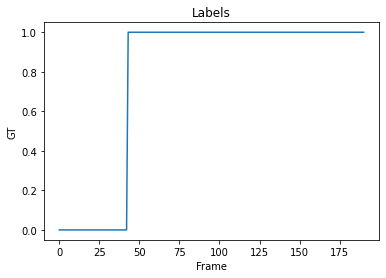

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test010
GT:  10
got model
(200, 227, 227, 1)
got data


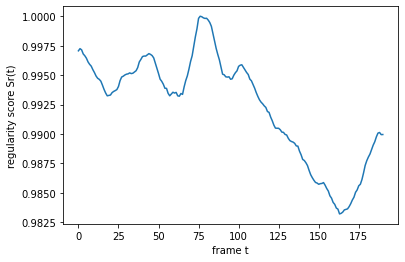

AUC:  0.003571428571428572
EER:  0.9629629629629629
EER THRESHOLD:  0.9899601196928804
Optimal threshold value is: 2.0


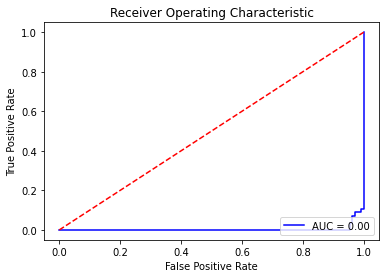

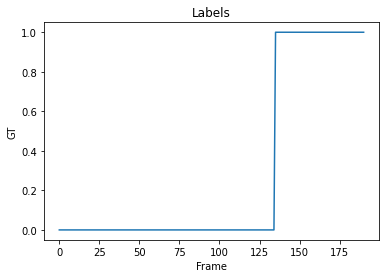

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test011
GT:  11
got model
(200, 227, 227, 1)
got data


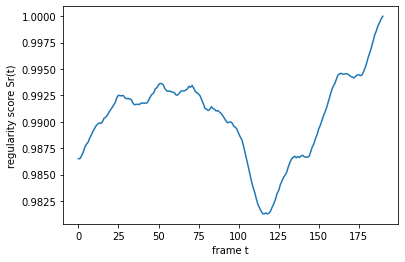

AUC:  0.8331140350877193
EER:  0.21875
EER THRESHOLD:  0.9913355775377405
Optimal threshold value is: 0.9915937988068844


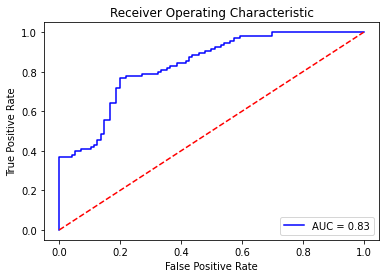

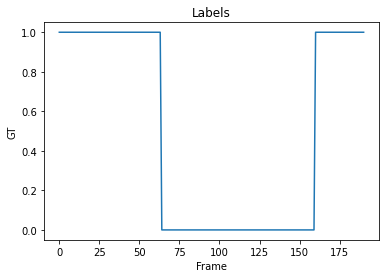

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test012
GT:  12
got model
(200, 227, 227, 1)
got data


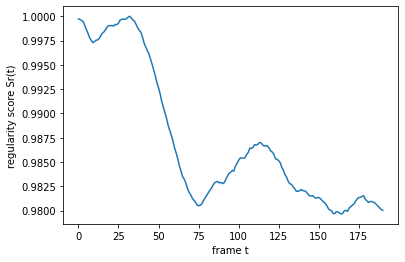

AUC:  0.9316363636363636
EER:  0.13636363636363635
EER THRESHOLD:  0.9827044178375046
Optimal threshold value is: 0.9827770675610439


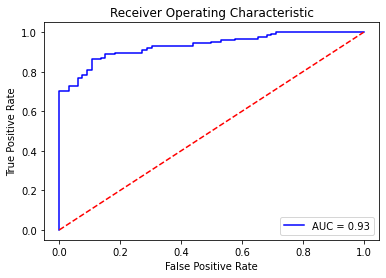

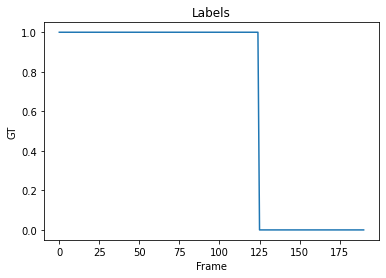

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test013
GT:  13
got model
(200, 227, 227, 1)
got data


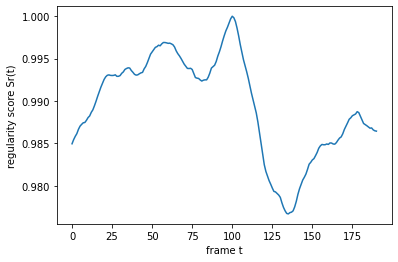

AUC:  0.2504966887417218
EER:  0.7284768211920529
EER THRESHOLD:  0.9873577714074241
Optimal threshold value is: 0.9832126873200383


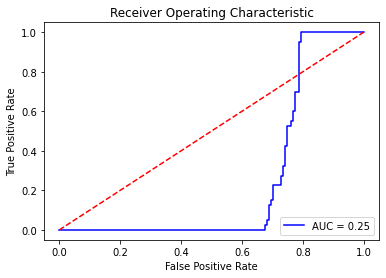

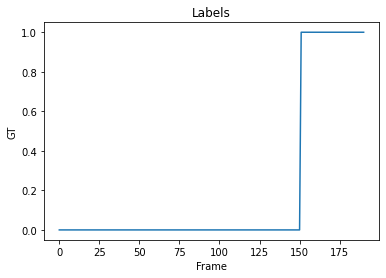

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014
GT:  14
got model
(200, 227, 227, 1)
got data


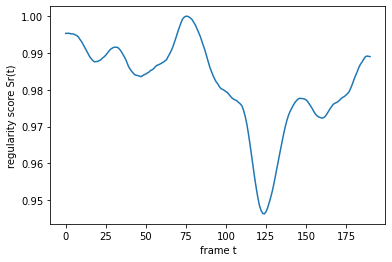

AUC:  0.9157894736842105
EER:  0.08421052631578947
EER THRESHOLD:  0.995334982883956
Optimal threshold value is: 0.995334982883956


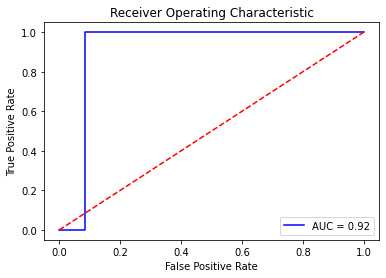

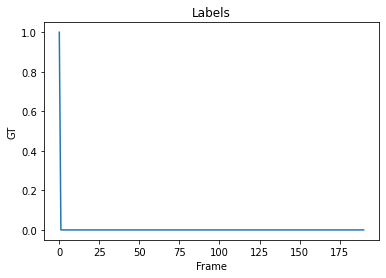

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test015
GT:  15
got model
(200, 227, 227, 1)
got data


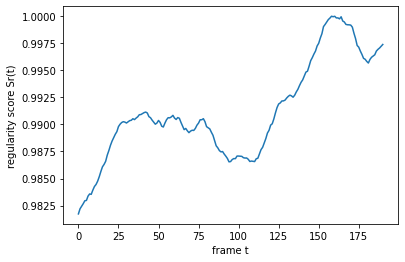

AUC:  0.00012840267077555178
EER:  1.0
EER THRESHOLD:  0.9925178890349609
Optimal threshold value is: 2.0


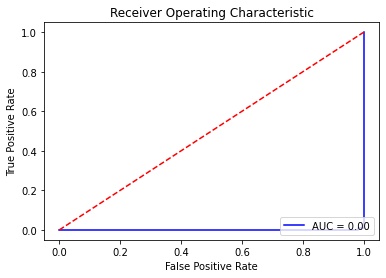

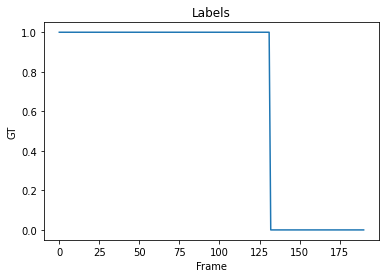

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test016
GT:  16
got model
(200, 227, 227, 1)
got data


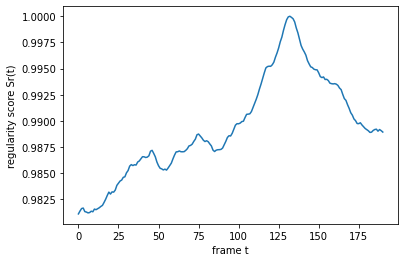

AUC:  0.04966504966504967
EER:  0.8243243243243243
EER THRESHOLD:  0.9895821291063679
Optimal threshold value is: 2.0


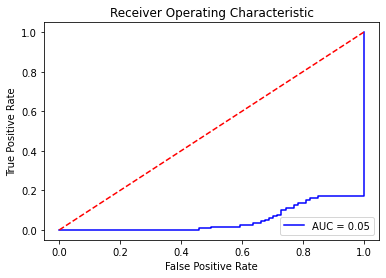

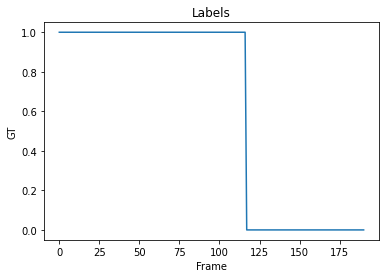

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test018
GT:  18
got model
(200, 227, 227, 1)
got data


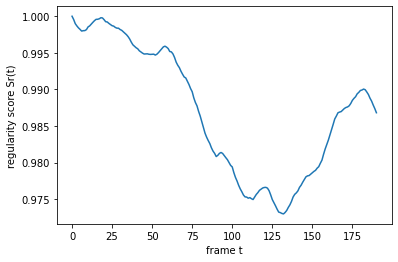

AUC:  0.56391429947039
EER:  0.4626865671641791
EER THRESHOLD:  0.9871892771888985
Optimal threshold value is: 0.9960930664805836


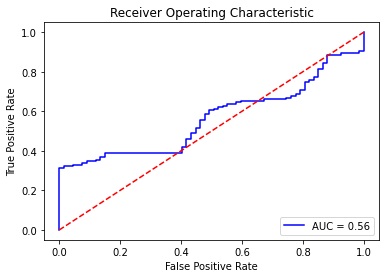

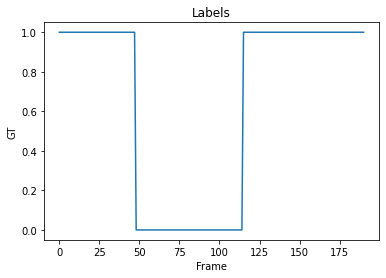

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019
GT:  19
got model
(200, 227, 227, 1)
got data


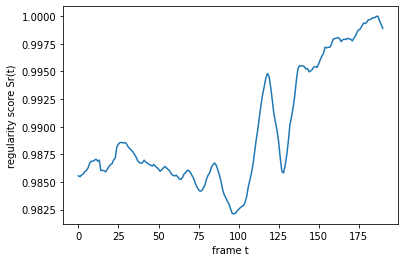

AUC:  0.8410344827586207
EER:  0.28
EER THRESHOLD:  0.9867251203875216
Optimal threshold value is: 0.9859148403101606


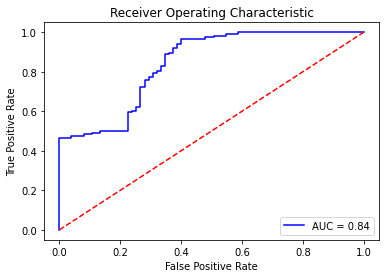

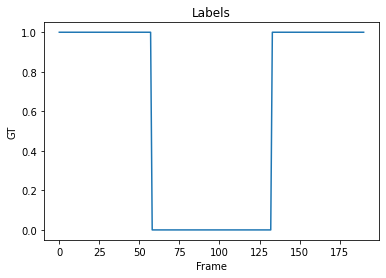

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020
GT:  20
got model
(200, 227, 227, 1)
got data


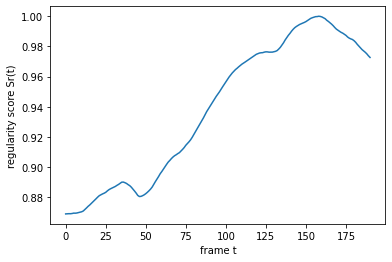

AUC:  0.28142493638676835
EER:  0.8702290076335878
EER THRESHOLD:  0.8902691020646691
Optimal threshold value is: 2.0


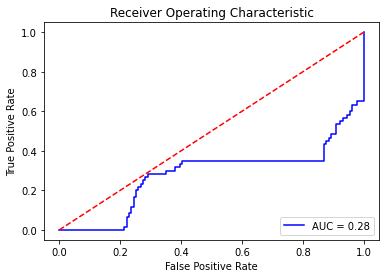

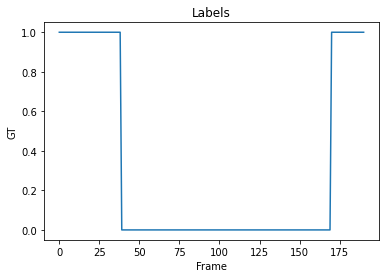

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test021
GT:  21
got model
(200, 227, 227, 1)
got data


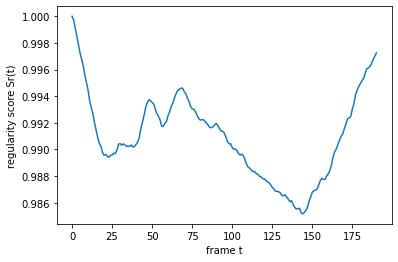

AUC:  0.7187951807228916
EER:  0.42771084337349397
EER THRESHOLD:  0.9915730840714941
Optimal threshold value is: 0.994463144772256


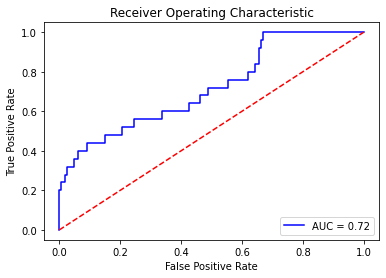

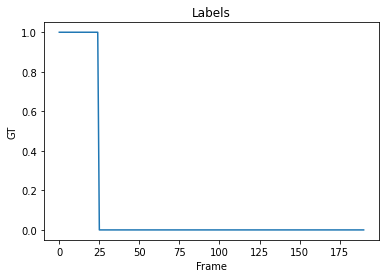

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test022
GT:  22
got model
(200, 227, 227, 1)
got data


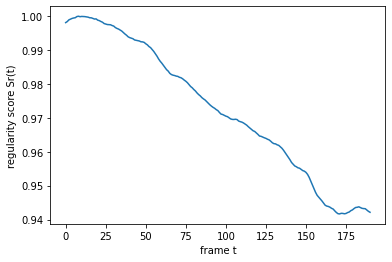

AUC:  0.10307692307692308
EER:  1.0
EER THRESHOLD:  0.9703587926537203
Optimal threshold value is: 0.9999443832972327


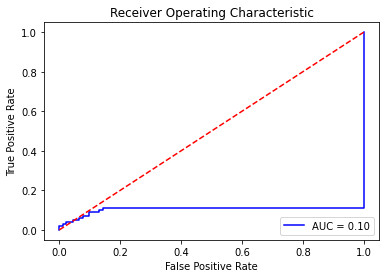

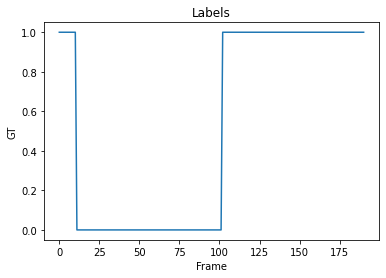

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test023
GT:  23
got model
(200, 227, 227, 1)
got data


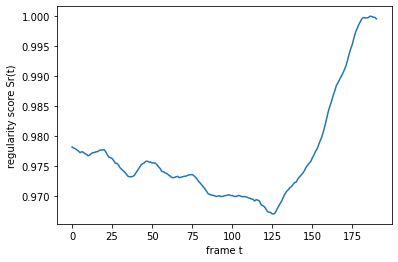

AUC:  0.9966279505432747
EER:  0.03821656050955414
EER THRESHOLD:  0.9778743981003674
Optimal threshold value is: 0.9778743981003674


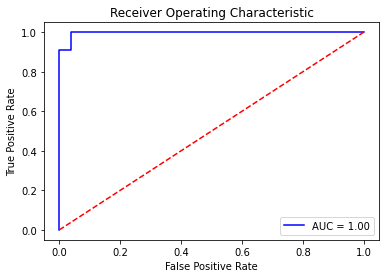

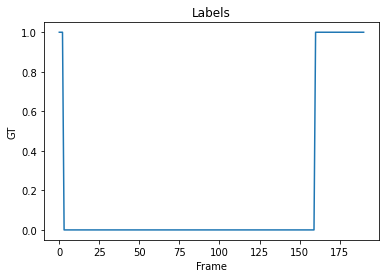

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024
GT:  24
got model
(200, 227, 227, 1)
got data


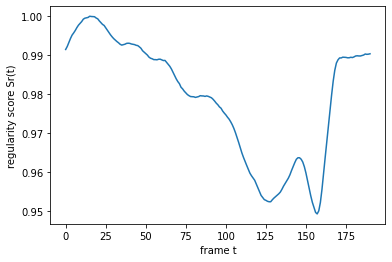

AUC:  0.9656688049417914
EER:  0.07377049180327869
EER THRESHOLD:  0.9893067579021919
Optimal threshold value is: 0.9893067579021919


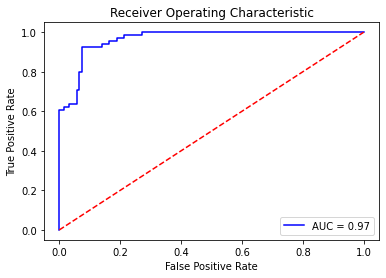

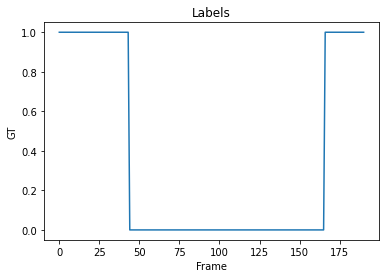

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test025
GT:  25
got model
(200, 227, 227, 1)
got data


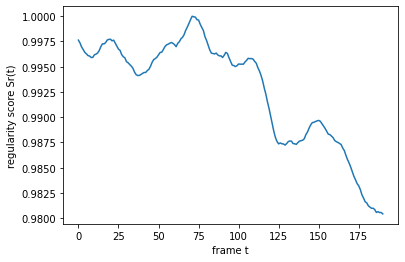

AUC:  0.2605263157894737
EER:  0.6458333333333334
EER THRESHOLD:  0.9952205825905491
Optimal threshold value is: 2.0


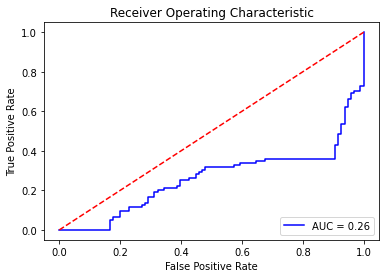

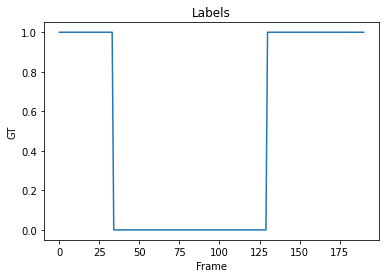

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test026
GT:  26
got model
(200, 227, 227, 1)
got data


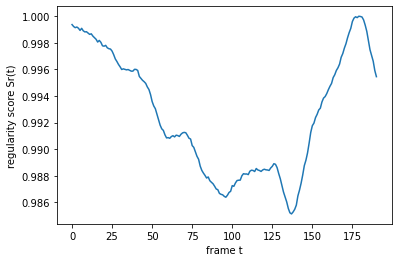

AUC:  0.9575108329321136
EER:  0.08955223880597014
EER THRESHOLD:  0.9898098731250847
Optimal threshold value is: 0.9908506099700106


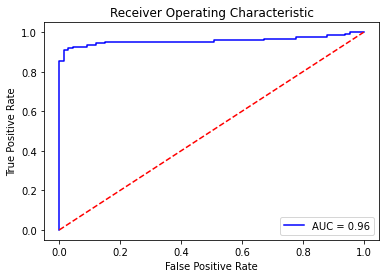

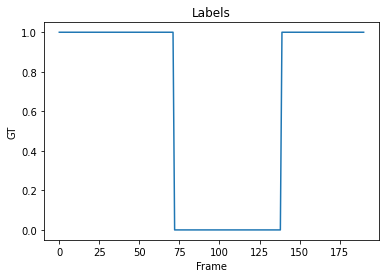

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test027
GT:  27
got model
(200, 227, 227, 1)
got data


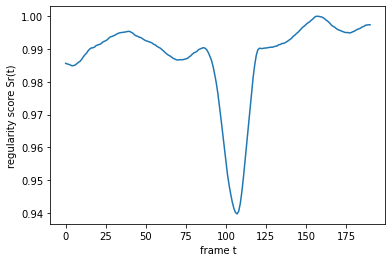

AUC:  0.8321987746766509
EER:  0.2831858407079646
EER THRESHOLD:  0.991686980997628
Optimal threshold value is: 0.9949042712880638


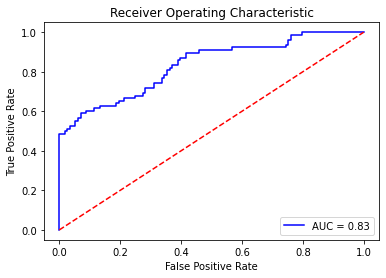

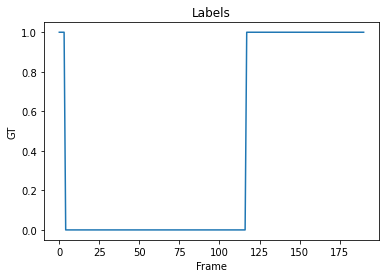

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test028
GT:  28
got model
(200, 227, 227, 1)
got data


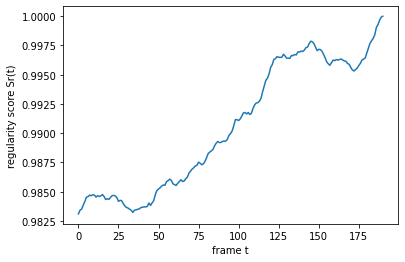

AUC:  0.0002195871761089151
EER:  1.0
EER THRESHOLD:  0.9910816845473027
Optimal threshold value is: 2.0


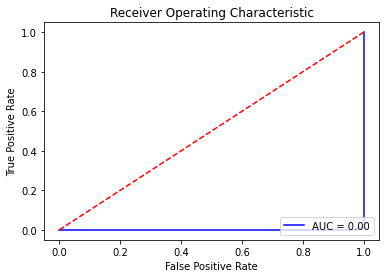

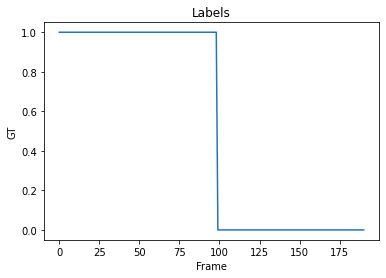

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test029
GT:  29
got model
(200, 227, 227, 1)
got data


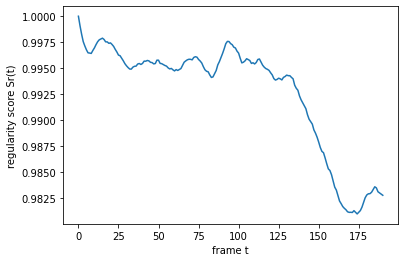

AUC:  0.20592224231464737
EER:  0.7341772151898734
EER THRESHOLD:  0.9952953574050315
Optimal threshold value is: 0.9973964939029538


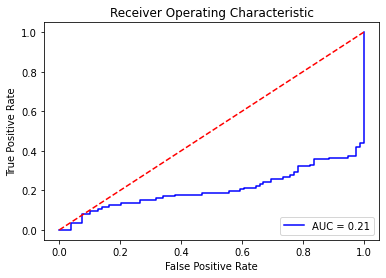

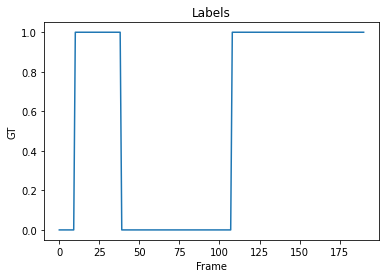

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test030
GT:  30
got model
(200, 227, 227, 1)
got data


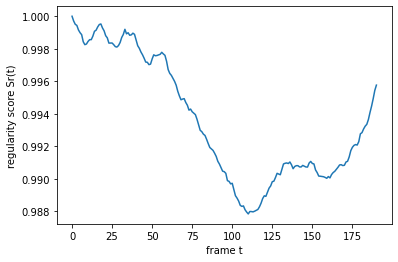

AUC:  0.49354491662183964
EER:  0.5
EER THRESHOLD:  0.9924251483135804
Optimal threshold value is: 0.99599245891133


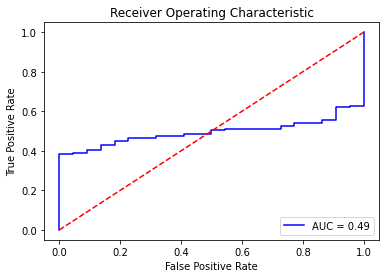

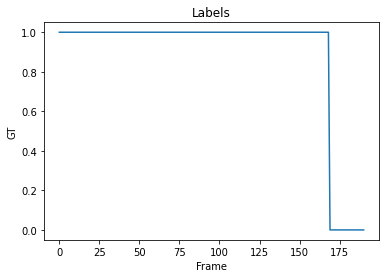

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test031
GT:  31
got model
(200, 227, 227, 1)
got data


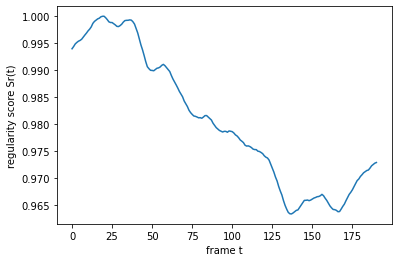

AUC:  0.2760714285714286
EER:  0.7142857142857143
EER THRESHOLD:  0.9718333036665405
Optimal threshold value is: 0.9678037027369664


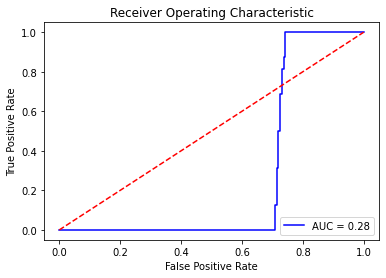

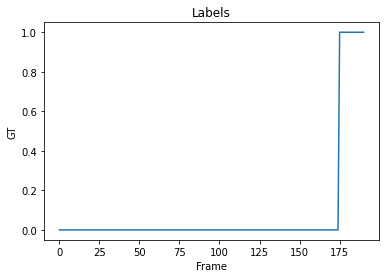

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032
GT:  32
got model
(200, 227, 227, 1)
got data


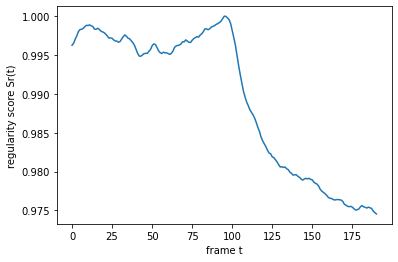

AUC:  0.025016458196181698
EER:  0.8571428571428571
EER THRESHOLD:  0.9952021204653954
Optimal threshold value is: 2.0


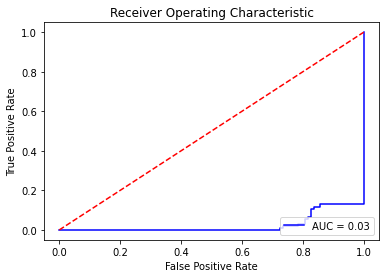

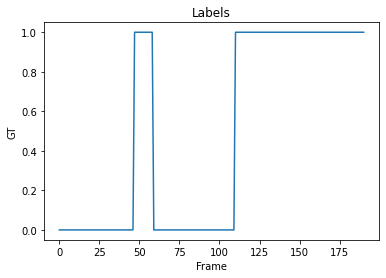

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test033
GT:  33
got model
(200, 227, 227, 1)
got data


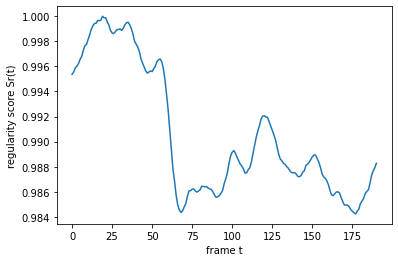

AUC:  0.0935483870967742
EER:  0.8125
EER THRESHOLD:  0.9865811198062775
Optimal threshold value is: 2.0


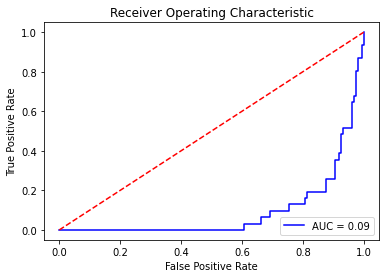

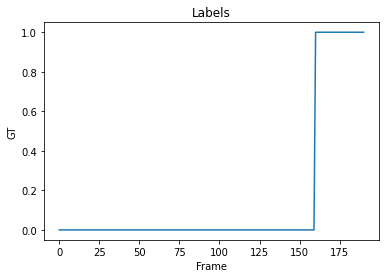

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test034
GT:  34
got model
(200, 227, 227, 1)
got data


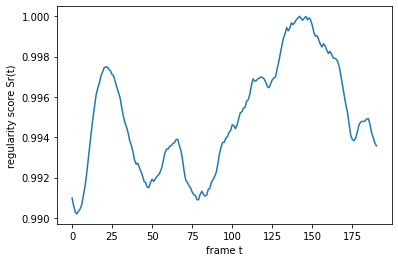

AUC:  0.8926436781609195
EER:  0.25
EER THRESHOLD:  0.9952079716730585
Optimal threshold value is: 0.9946449805645565


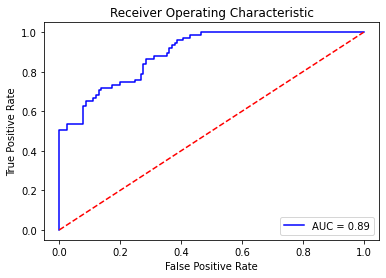

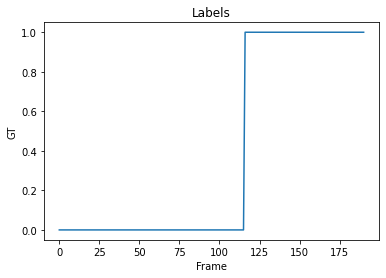

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test035
GT:  35
got model
(200, 227, 227, 1)
got data


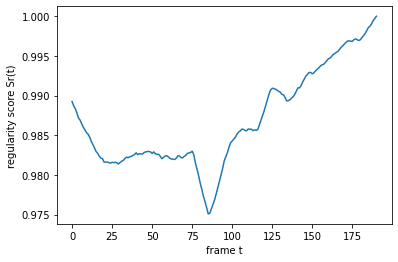

AUC:  0.17319819819819818
EER:  0.8288288288288288
EER THRESHOLD:  0.9838317060634273
Optimal threshold value is: 0.9799316471796173


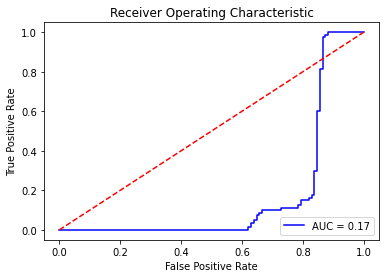

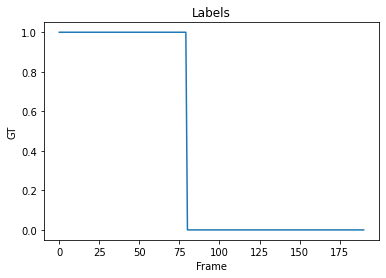

PATH:  UCSD_v5/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036
GT:  36
got model
(200, 227, 227, 1)
got data


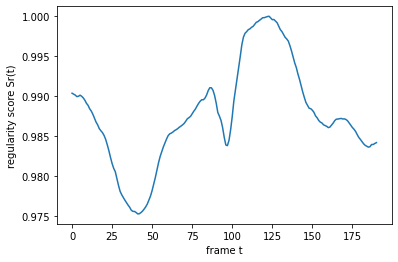

AUC:  0.8067558675148059
EER:  0.3191489361702128
EER THRESHOLD:  0.9870651209765345
Optimal threshold value is: 0.9897751393834898


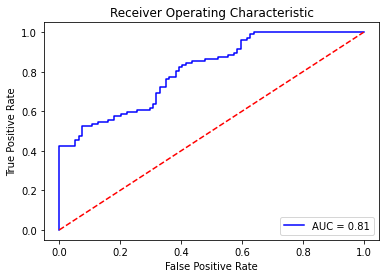

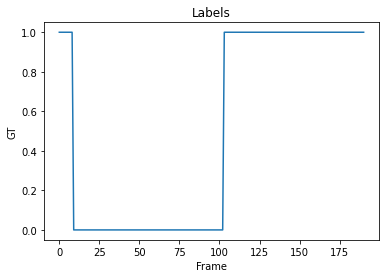

AUC:  0.4916344771037373
EER:  0.5380680841981541


In [12]:
from os import listdir
from os.path import isfile, join, isdir


clips = []
# loop over the training folders (Train000,Train001,..)
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  if(i == 16): #skip clip 17
    continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr, before_reconstuction = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])